In [1]:
import os
os.environ['OMP_NUM_THREADS']='2'
os.environ['LD_LIBRARY_PATH']=''

In [2]:
import numpy as np
import h5py
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from tqdm.std import trange
from torch.utils.data import dataloader
from pixelshuffle1d import PixelShuffle1D, PixelUnshuffle1D

/home/pz281@ad.eng.cam.ac.uk/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Generate data

$-\bigtriangledown\cdot  \left ( exp(\kappa ) \bigtriangledown u\left ( \textbf{x} \right )\right )=f\left ( \textbf{x} \right )$ 

$x\subseteq \left [ 0,1 \right ], y\subseteq \left [ 0,1 \right ]$ 

$f(x) = -(8π^2) * sin(2aπ(x+c)) * sin(2bπ(y+d))$

$a,b \in [0,2]; c,d \in [-2\pi,2\pi]$

$u(0,y)=u(1,y)=u(x,0)=u(x,1)=0$

### Finite-difference

In [3]:
def generate_data(N,type):
    h=1/N
    x=np.arange(0,1.0001,h)
    y=np.arange(0,1.0001,h)
    
    w=np.zeros((N+1,N+1))

    for j in range (0,N):
        w[0,j]=0 #Lower Boundary
        w[N,j]=0 #Upper Boundary
    
    N2=(N-1)*(N-1)
    A=np.zeros((N2,N2))
    ## Diagonal            
    for i in range (0,N-1):
        for j in range (0,N-1):           
            A[i+(N-1)*j,i+(N-1)*j]=-4

    # LOWER DIAGONAL        
    for i in range (1,N-1):
        for j in range (0,N-1):           
            A[i+(N-1)*j,i+(N-1)*j-1]=1   
    # UPPPER DIAGONAL        
    for i in range (0,N-2):
        for j in range (0,N-1):           
            A[i+(N-1)*j,i+(N-1)*j+1]=1   

    # LOWER IDENTITY MATRIX
    for i in range (0,N-1):
        for j in range (1,N-1):           
            A[i+(N-1)*j,i+(N-1)*(j-1)]=1        
        
        
    # UPPER IDENTITY MATRIX
    for i in range (0,N-1):
        for j in range (0,N-2):           
            A[i+(N-1)*j,i+(N-1)*(j+1)]=1
    Ainv=np.linalg.inv(A) 
    
    r=np.zeros(N2)
    
    a = np.random.uniform(0,2)
    b = np.random.uniform(0,2)
    c = np.random.uniform(-2*np.pi,2*np.pi)
    d = np.random.uniform(-2*np.pi,2*np.pi)

    # vector r      
    for i in range (0,N-1):
        for j in range (0,N-1):
            if type == "mean":      
                r[i+(N-1)*j]=-(8*np.pi**2) * np.sin(2*np.pi*x[i+1]) * np.sin(2*np.pi*y[j+1])*h**2
            elif type == "test":
                r[i+(N-1)*j]=-(8*np.pi**2) * np.sin(2*2*np.pi*(x[i+1]-np.pi)) * np.sin(2*2*np.pi*(y[j+1]+2*np.pi))*h**2
            else:
                r[i+(N-1)*j]=-(8*np.pi**2) * np.sin(2*a*np.pi*(x[i+1]+c)) * np.sin(2*b*np.pi*(y[j+1]+d))*h**2
    
    C=np.dot(Ainv,r)
    w[1:N,1:N]=C.reshape((N-1,N-1))
    
    return w, r, A, x, y
    

In [4]:
N_low = 19
N_high = 99
w_low, r_low, A_low, x_low, y_low = generate_data(N_low,"mean")
w_high, r_high, A_high, x_high, y_high = generate_data(N_high,"mean")

###  Collect high-res labels

In [36]:
num = 63
total = generate_data(N_high,"high")[0]
total = total.reshape(1,w_high.shape[0],-1)
for i in tqdm(range(num)):
    w_high = generate_data(N_high,"high")[0]
    total = np.concatenate([total,w_high.reshape(1,w_high.shape[0],-1)],axis=0)

100%|██████████| 63/63 [22:45<00:00, 21.68s/it]


In [38]:
# Save to h5py file
with h5py.File('high_res.h5', 'w') as hf:
    hf.create_dataset("high_res",  data=total)

In [52]:
with h5py.File('high_res.h5', 'r') as hf:
    data = hf['high_res'][:]

### Plot

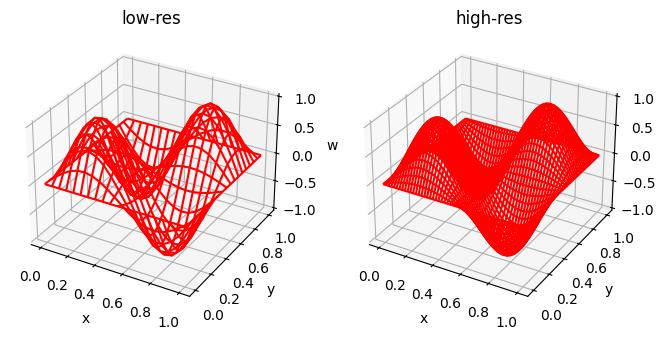

In [5]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
# Plot a basic wireframe.
X, Y = np.meshgrid(x_low, y_low)
ax1.plot_wireframe(X, Y, w_low,color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('low-res')
ax2 = fig.add_subplot(122, projection='3d')
# Plot a basic wireframe.
X, Y = np.meshgrid(x_high,y_high)
ax2.plot_wireframe(X, Y, w_high,color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('high-res')
plt.show()

Text(0, 0.5, 'y')

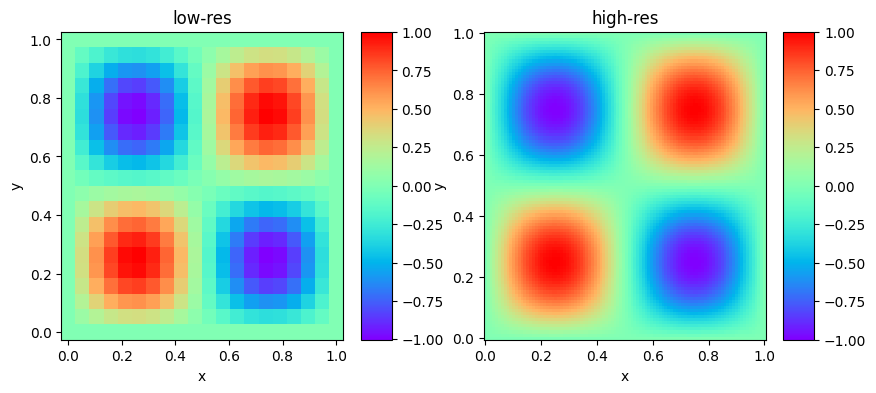

In [6]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.pcolormesh(x_low,y_low, w_low, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.xlabel('x')
plt.ylabel('y')
plt.title('low-res')
plt.subplot(1,2,2)
plt.pcolormesh(x_high,y_high,w_high, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('high-res')
plt.xlabel('x')
plt.ylabel('y')

## Calculate prior of $u^l$

In [7]:
def gaussian_kernal(x1,x2,y1,y2,l,sigma,N):
    m = (N-1)*(N-1)
    n = (N-1)*(N-1)
    dist_matrix = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            dist_matrix[i][j] = (y1[(i+1)%(N-1)]-y2[(i+1)%(N-1)])**2 + (x1[i//(N-1)+1]-x2[i//(N-1)+1])**2
            # dist_matrix[i][j] = (x1[(i+1)%(N-1)]-x2[(i+1)%(N-1)])**2 + (y1[i//(N-1)+1]-y2[i//(N-1)+1])**2
            #dist_matrix[i][j] = np.sum([x1[(i+1)%(N-1)],y1[i//(N-1)+1]]-[x2[(i+1)%(N-1)],y2[i//(N-1)+1]])**2
    
    return sigma ** 2 * np.exp(-0.5 / l ** 2 * dist_matrix)

# Define mean and covariance matrix of f
m = r_low
G = gaussian_kernal(x_low,x_low,y_low,y_low,0.1,0.3,N_low)

In [11]:
m.shape

(324,)

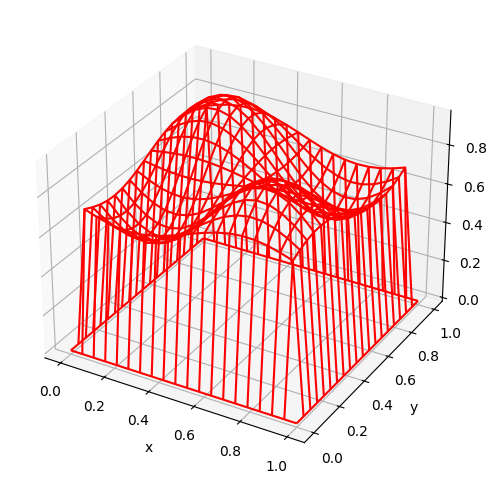

In [12]:
# Take one sample from the prior
C = np.random.multivariate_normal(m.ravel(),G)
w_sample = np.copy(w_low)
w_sample[1:N_low,1:N_low]=C.reshape((N_low-1,N_low-1))

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
# Plot a basic wireframe.
X, Y = np.meshgrid(x_low, y_low)
ax.plot_wireframe(X, Y, w_sample,color='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('w')
plt.show()

In [8]:
# Mean and covariance matrix of u
mean_u = np.matmul(np.linalg.inv(A_low),m)
covariance_u = np.matmul(np.linalg.solve(A_low,G),np.linalg.inv(A_low).T)

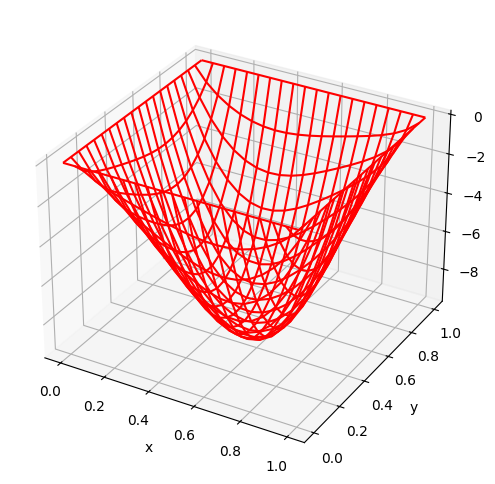

In [9]:
# Take one sample from the prior
C = np.random.multivariate_normal(mean_u.ravel(),covariance_u)
w_sample = np.copy(w_low)
w_sample[1:N_low,1:N_low]=C.reshape((N_low-1,N_low-1))

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
# Plot a basic wireframe.
X, Y = np.meshgrid(x_low, y_low)
ax.plot_wireframe(X, Y, w_sample,color='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('w')
plt.show()

Text(0, 0.5, 'y')

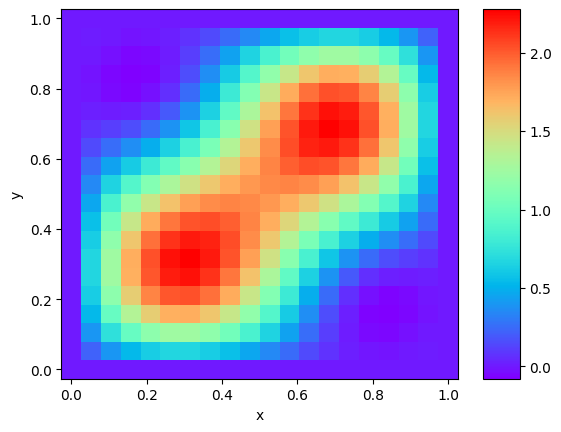

In [10]:
plt.pcolormesh(x_low,y_low, w_sample, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.xlabel('x')
plt.ylabel('y')

## Upscaling network

In [11]:
class UpScale(torch.nn.Module):
    def __init__(self):
        super(UpScale, self).__init__()
        self.layer1 = torch.nn.Conv2d(in_channels=1, out_channels=25, kernel_size=3, stride=1,padding=1)
        self.act1 = torch.nn.ReLU()
        self.layer2 = torch.nn.Conv2d(in_channels=25, out_channels=50, kernel_size=3, stride=1,padding=1)
        #self.layer3 = torch.nn.Conv1d(in_channels=6, out_channels=6, kernel_size=3, stride=1,padding=1)
        self.layer4 = torch.nn.Conv2d(in_channels=50, out_channels=25, kernel_size=3, stride=1,padding=1)
        self.PReLU = torch.nn.PReLU()
        self.shuffle = torch.nn.PixelShuffle(5)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.PReLU(x)
        #x = self.layer3(x)+x1
        x = self.layer4(x)
        x = self.shuffle(x)

        # log_probs = torch.nn.functional.log_softmax(x, dim=1)

        return x

model = UpScale()
input = torch.tensor(w_low.reshape(1, w_low.shape[0],-1))
input = input.to(torch.float32)
print(model(input).shape)

torch.Size([1, 100, 100])


## Dataloader

In [12]:
with h5py.File('high_res.h5', 'r') as hf:
    data = hf['high_res'][:]

In [64]:
trainset = torch.utils.data.DataLoader(dataset=data,batch_size=1,shuffle=False)

## Training

In [13]:
# Initialise network
model = UpScale()
optim = torch.optim.Adam(model.parameters(), lr = 0.001)

# Initialise parameters
sigma = 1
# Sigma = torch.eye((N_high+1)**2)
N_samples = 20
batch_size = 1
epoch_number = 200
minimum_loss = 1000000

# Sample from p(u^l)
'''sample_ul = []
for i in range(N_samples):
    u = np.zeros((1,N_low))
    u[0,1:N_low-1] = np.random.multivariate_normal(mean_u.ravel(),covariance_u).reshape(1,-1)
    sample_ul.append(u)'''

for epoch in range(epoch_number):
    loss = 0
    for i in range(64):
        # Calculate log likelihood based on all low-resolution samples
        log_likelihood = []
        # Log the maximum log likelihood and its index
        max_index = 0
        log_lik_max = -1000000
        w_high = data[i]
        w_high = torch.tensor(w_high.reshape(1,w_high.shape[0],-1))
        w_high = w_high.to(torch.float32)
        w_high = w_high.reshape(1,-1)
        for i in range(N_samples):
            input = np.zeros((N_low+1,N_low+1))
            input[1:N_low,1:N_low] = np.random.multivariate_normal(mean_u.ravel(),covariance_u).reshape(N_low-1,N_low-1)
            input = torch.tensor(input.reshape(1,input.shape[0],-1))
            input = input.to(torch.float32)
            output = model(input)
            output = output.reshape(1,-1)
            log_lik = - 0.5 /sigma**2 * torch.sum((output-w_high)**2)
            # log_lik = - 0.5 * torch.matmul(torch.matmul(output-w_high,10000*Sigma),torch.transpose(output-w_high,0,1))
            log_likelihood.append(log_lik)
            if log_lik > log_lik_max:
                max_index = i
                log_lik_max = log_lik
        
        # Calculate log marginal likelihood
        max_likelihood = log_likelihood[max_index]
        value = torch.exp(log_likelihood[0]-max_likelihood)/N_samples
        for i in range(1,N_samples):
            value += torch.exp(log_likelihood[i]-max_likelihood)/N_samples
        log_marginal = max_likelihood + torch.log(value)
        
        loss += -log_marginal
        
    optim.zero_grad()
    if loss < minimum_loss:
        torch.save(model.state_dict(), 'best_2D_model_generalise.pth')
        minimum_loss = loss
    loss.backward()
    optim.step()
    
    '''if (epoch+1)%100 == 0:
        print("Epoch: {}".format(epoch), "Loss: {}".format(loss.item()))'''
    print("Epoch: {}".format(epoch), "Loss: {}".format(loss.item()))


Epoch: 0 Loss: 147803.859375
Epoch: 1 Loss: 127523.1171875
Epoch: 2 Loss: 111203.8828125
Epoch: 3 Loss: 105898.2421875
Epoch: 4 Loss: 102025.5625
Epoch: 5 Loss: 97713.5078125
Epoch: 6 Loss: 75729.9375
Epoch: 7 Loss: 68025.3046875
Epoch: 8 Loss: 67734.4140625
Epoch: 9 Loss: 70973.890625
Epoch: 10 Loss: 69767.9296875
Epoch: 11 Loss: 77947.34375
Epoch: 12 Loss: 66545.59375
Epoch: 13 Loss: 61595.11328125
Epoch: 14 Loss: 66844.921875
Epoch: 15 Loss: 57967.09765625
Epoch: 16 Loss: 59577.953125
Epoch: 17 Loss: 58356.75390625
Epoch: 18 Loss: 60044.9921875
Epoch: 19 Loss: 56583.45703125
Epoch: 20 Loss: 54451.9453125
Epoch: 21 Loss: 59338.37109375
Epoch: 22 Loss: 56953.48046875
Epoch: 23 Loss: 58009.59765625
Epoch: 24 Loss: 61394.4609375
Epoch: 25 Loss: 56246.3359375
Epoch: 26 Loss: 56013.703125
Epoch: 27 Loss: 55013.49609375
Epoch: 28 Loss: 57008.40234375
Epoch: 29 Loss: 58425.296875
Epoch: 30 Loss: 58501.95703125
Epoch: 31 Loss: 57203.3046875
Epoch: 32 Loss: 54986.9453125
Epoch: 33 Loss: 54241

In [ ]:
# Initialise network
model = UpScale()
optim = torch.optim.Adam(model.parameters(), lr = 0.001)

# Initialise parameters
sigma = 1
# Sigma = torch.eye((N_high+1)**2)
N_samples = 20
batch_size = 16
epoch_number = 2000
minimum_loss = 10000

# Sample from p(u^l)
'''sample_ul = []
for i in range(N_samples):
    u = np.zeros((1,N_low))
    u[0,1:N_low-1] = np.random.multivariate_normal(mean_u.ravel(),covariance_u).reshape(1,-1)
    sample_ul.append(u)'''

for epoch in range(epoch_number):
    for batch_num, label in enumerate(trainset):
        # Calculate log likelihood based on all low-resolution samples
        log_likelihood = []
        # Log the maximum log likelihood and its index
        max_index = 0
        log_lik_max = -1000000
        for i in tqdm(range(N_samples)):
            input = np.zeros((batch_size,N_low+1,N_low+1))
            for j in range(batch_size):
                input[j,1:N_low,1:N_low] = np.random.multivariate_normal(mean_u.ravel(),covariance_u).reshape(N_low-1,N_low-1)
            input = torch.tensor(input.reshape(16,1,input.shape[1],-1))
            input = input.to(torch.float32)
            output = model(input)
            output = output.reshape(batch_size,1,-1)
            label = label.reshape(batch_size,1,-1)
            log_lik = - 0.5 /sigma**2 * torch.sum((output-w_high)**2)
            # log_lik = - 0.5 * torch.matmul(torch.matmul(output-w_high,10000*Sigma),torch.transpose(output-w_high,0,1))
            log_likelihood.append(log_lik)
            if log_lik > log_lik_max:
                max_index = i
                log_lik_max = log_lik
        
        # Calculate log marginal likelihood
        max_likelihood = log_likelihood[max_index]
        value = torch.exp(log_likelihood[0]-max_likelihood)/N_samples
        for i in range(1,N_samples):
            value += torch.exp(log_likelihood[i]-max_likelihood)/N_samples
        log_marginal = max_likelihood + torch.log(value)
        
        optim.zero_grad()
        loss = -log_marginal
        if loss < minimum_loss:
            torch.save(model.state_dict(), 'best_2D_model_general.pth')
            minimum_loss = loss
        loss.backward()
        optim.step()
    
    '''if (epoch+1)%100 == 0:
        print("Epoch: {}".format(epoch), "Loss: {}".format(loss.item()))'''
    print("Epoch: {}".format(epoch), "Loss: {}".format(loss.item()))


## Testing

### Test with mean input

In [14]:
N_low = 19
N_high = 99
w_low, r_low, A_low, x_low, y_low = generate_data(N_low,"mean")
w_high, r_high, A_high, x_high, y_high = generate_data(N_high,"mean")

In [15]:
# Test with input A^(-1)b
model = UpScale()
model.load_state_dict(torch.load('best_2D_model_generalise2.pth'))
input = w_low
input = torch.tensor(input.reshape(1,input.shape[0],-1))
input = input.to(torch.float32)
output = model(input)
y_input = input.detach().numpy()
y = output.detach().numpy()

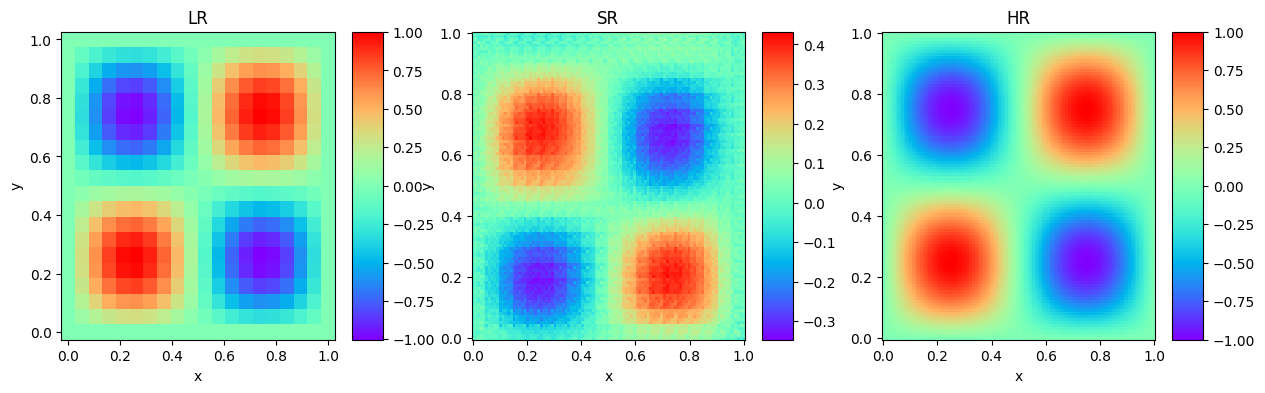

L2 Error: 0.42736522337209865


In [16]:
fig = plt.figure(figsize=(15,4))
# Around 200 epochs
plt.subplot(1,3,1)
plt.pcolormesh(x_low,y_low,w_low, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,3,2)
plt.pcolormesh(x_high, y_high, y[0], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('SR')
plt.xlabel('x')
plt.ylabel('y')
# Around 200 epochs
plt.subplot(1,3,3)
plt.pcolormesh(x_high, y_high, w_high, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('HR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


error = abs(w_high - y[0])
print('L2 Error:', (error**2).sum()/error.shape[0]**2)

### Test with others

In [17]:
N_low = 19
N_high = 99
w_low, r_low, A_low, x_low, y_low = generate_data(N_low,"test")
w_high, r_high, A_high, x_high, y_high = generate_data(N_high,"test")

In [20]:
model = UpScale()
model.load_state_dict(torch.load('best_2D_model_generalise.pth'))
input = w_low
input = torch.tensor(input.reshape(1,input.shape[0],-1))
input = input.to(torch.float32)
output = model(input)
y_input = input.detach().numpy()
y = output.detach().numpy()

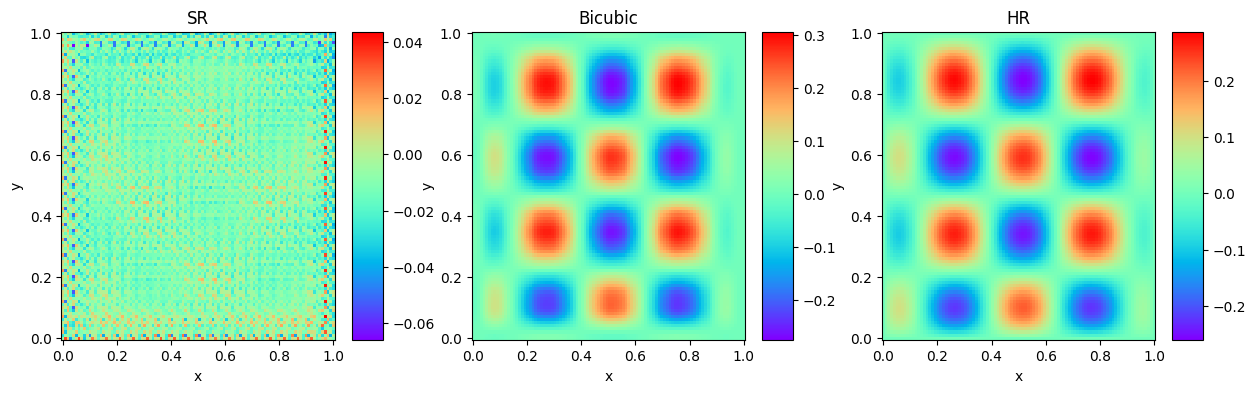

SR L2 Error: 0.013244888109496259
Bicubic L2 Error: 0.0005818359432461894


In [21]:
fig = plt.figure(figsize=(15,4))
# Around 200 epochs
'''plt.subplot(1,4,1)
plt.pcolormesh(x_low,y_low,w_low, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('LR')
plt.xlabel('x')
plt.ylabel('y')'''
plt.subplot(1,3,1)
plt.pcolormesh(x_high, y_high, y[0], cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('SR')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1,3,2)
w_high_bicubic = cv2.resize(w_low, dsize=(100,100), interpolation=cv2.INTER_CUBIC)
plt.pcolormesh(x_high, y_high, w_high_bicubic, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('Bicubic')
plt.xlabel('x')
plt.ylabel('y')
# Around 200 epochs
plt.subplot(1,3,3)
plt.pcolormesh(x_high, y_high, w_high, cmap='rainbow')
cbar = plt.colorbar(pad=0.05, aspect=10)
#cbar.mappable.set_clim(0, 0.15)
plt.title('HR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


error1 = abs(w_high - y[0])
error2 = abs(w_high_bicubic - w_high)
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)
print('Bicubic L2 Error:', (error2**2).sum()/error2.shape[0]**2)